# Model A: Probabilistic Mutation Accumulation Model

This notebook implements **Model A** from the proposal: a probabilistic framework with mutation-rate variation (p ~ LogNormal), DNA repair efficiency (r), and clonal threshold (C).

## Overview

The probabilistic mutation-accumulation model expresses the probability of malignancy as:
$$P = 1 - (1 - p_{cell})^M$$

where $p_{cell}$ is the probability that a single clone has $\geq C$ driver mutations, and $M$ is the number of stem-cell clones.

The model incorporates:
- **Mutation probability (p)**: Per-division driver-mutation probability
- **Clonal threshold (C)**: Number of driver mutations required for malignancy (C=1: single hit, C>1: multi-hit)
- **DNA repair efficiency (r)**: Effective mutation probability becomes $p_{eff} = p \cdot (1-r)$
- **Stem-cell divisions**: Age-dependent accumulation of mutations

## Method

1. Load USCS age-specific cancer incidence data
2. Initialize probabilistic mutation-accumulation model with optimized parameters
3. Fit model to observed age-incidence patterns
4. Evaluate model fit and compare with Model B and Model C


In [94]:
# Import libraries
import sys
from pathlib import Path
import importlib

# Add project root to path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Import project modules
from src.data_loader import (
    load_uscs_data,
    prepare_pediatric_brain_data,
    prepare_all_sites_age_data
)

# Force reload modules to pick up new functions/parameters
# This is useful when the modules have been updated
if 'src.models' in sys.modules:
    importlib.reload(sys.modules['src.models'])
if 'src.visualization' in sys.modules:
    importlib.reload(sys.modules['src.visualization'])

from src.models import (
    MutationAccumulationModel,
    prepare_age_incidence_data
)

from src.visualization import (
    plot_pediatric_brain_distribution,
    plot_pediatric_brain_by_year,
    plot_pediatric_brain_trend,
    plot_age_incidence_model,
    plot_age_incidence_curve,
    plot_parameter_sensitivity,
    plot_multi_year_comparison,
    plot_residual_analysis
)

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 11

print("✓ All modules imported successfully!")


✓ All modules imported successfully!


## Data Sources: USCS (current) and TCGA (planned)

This notebook currently uses **USCS (U.S. Cancer Statistics)** ASCII incidence tables as the primary data source (see `data/USCS-1999-2022-ASCII/`).

TCGA (The Cancer Genome Atlas) data under `data/TCGA/` is planned for future extensions, for example to link tumor mutation burden and driver panels back to the age–incidence patterns modeled here.



### TCGA DR44 project overview (genomic data for mutation burden)

In addition to population-level incidence data (USCS), this project includes **TCGA DR44 project manifests** under `data/TCGA/`.
These describe whole-genome and related files (e.g., somatic mutation VCFs) for many cancer projects (TCGA and other programs).

In the context of **Model A (probabilistic mutation-accumulation)**, TCGA data are useful for:

- Quantifying **tumor mutation burden** and driver panels across tissues.
- Relating observed mutation load back to the parameters \(p\) (per-division driver mutation probability) and \(M\) (number of relevant stem-cell clones).
- Checking whether tissues with high LSCD and/or higher modeled mutation probabilities also show higher TCGA mutation burdens.


In [95]:
# Quick TCGA DR44 file summary: projects and file categories
from pathlib import Path

tcga_root = project_root / "data" / "TCGA"
new_files_path = tcga_root / "DR44_new_files_20251029.tsv"

if new_files_path.exists():
    tcga_new_files = pd.read_csv(new_files_path, sep="\t")
    print(f"Loaded DR44 new files table from: {new_files_path}")
    print(f"Rows: {tcga_new_files.shape[0]}, Columns: {tcga_new_files.shape[1]}")
    print("Columns:", list(tcga_new_files.columns))

    # Summarize number of data/index files per project
    project_summary = (
        tcga_new_files
        .groupby(["project_id", "category"])
        .size()
        .reset_index(name="n_files")
        .sort_values(["project_id", "category"])
    )

    print("\nPer-project file counts (first 15 rows):")
    display(project_summary.head(15))

    # Focus on TCGA projects only for a concise overview
    tcga_only = project_summary[project_summary["project_id"].str.startswith("TCGA-")].copy()
    tcga_data_files = tcga_only[tcga_only["category"] == "data_file"].copy()
    top_tcga_projects = (
        tcga_data_files
        .sort_values("n_files", ascending=False)
        .head(10)
    )

    print("\nTop 10 TCGA projects by number of data files in DR44:")
    display(top_tcga_projects)
else:
    print(f"TCGA DR44 new-files table not found at: {new_files_path}")
    print("If you want to use TCGA summaries, ensure DR44_new_files_20251029.tsv exists under data/TCGA/.")


Loaded DR44 new files table from: D:\资料\graduate\202509\INTRO-GENOMIC INFO SCI & TECH\FinalProject\data\TCGA\DR44_new_files_20251029.tsv
Rows: 89096, Columns: 8
Columns: ['id', 'filename', 'md5', 'size', 'state', 'acl', 'project_id', 'category']

Per-project file counts (first 15 rows):


,project_id,category,n_files
0,APOLLO-LUAD,data_file,87
1,APOLLO-LUAD,index_file,87
2,APOLLO-OV,data_file,1655
3,APOLLO-OV,index_file,465
4,CCDI-MCI,data_file,14457
5,CCDI-MCI,index_file,6117
6,CGCI-BLGSP,data_file,355
7,CGCI-BLGSP,index_file,283
8,CGCI-HTMCP-CC,data_file,137
9,CGCI-HTMCP-CC,index_file,137



Top 10 TCGA projects by number of data files in DR44:


,project_id,category,n_files
89,TCGA-TGCT,data_file,1177
41,TCGA-BRCA,data_file,1132
39,TCGA-BLCA,data_file,822
87,TCGA-STAD,data_file,730
91,TCGA-THCA,data_file,629
67,TCGA-LUAD,data_file,612
95,TCGA-UCEC,data_file,591
55,TCGA-HNSC,data_file,574
59,TCGA-KIRC,data_file,565
63,TCGA-LGG,data_file,554


In [96]:
# Load example LSCD per tissue table so Model A can reference LSCD
from pathlib import Path

lscd_path = project_root / "data" / "LSCD_example.csv"
if lscd_path.exists():
    lscd_df = pd.read_csv(lscd_path)
    print(f"Loaded LSCD table from: {lscd_path}")
    display(lscd_df)

    # Extract LSCD estimate for colon and rectum (if present)
    colon_lscd = lscd_df.loc[lscd_df["site"] == "Colon and Rectum", "LSCD_estimate"]
    if not colon_lscd.empty:
        print(f"LSCD estimate for Colon and Rectum: {colon_lscd.iloc[0]:.3e}")
else:
    print(f"LSCD_example.csv not found at: {lscd_path}")
    lscd_df = None



Loaded LSCD table from: D:\资料\graduate\202509\INTRO-GENOMIC INFO SCI & TECH\FinalProject\data\LSCD_example.csv


,site,LSCD_estimate
0,Colon and Rectum,1.000000e+11
1,Lung and Bronchus,1.200000e+11
2,Female Breast,5.000000e+10
3,Prostate,6.000000e+10
4,Brain and Other Nervous System,2.000000e+10


LSCD estimate for Colon and Rectum: 1.000e+11


## 1. Load and Prepare Data


In [97]:
# Load data
print("Loading USCS data...")
brain_by_site, by_age = load_uscs_data()

print(f"✓ BRAINBYSITE shape: {brain_by_site.shape}")
print(f"✓ BYAGE shape: {by_age.shape}")

# Prepare data
pediatric_brain = prepare_pediatric_brain_data(brain_by_site)
all_sites_age_inc = prepare_all_sites_age_data(by_age)

print(f"\n✓ Pediatric brain tumor records: {pediatric_brain.shape[0]}")
print(f"✓ Age-specific incidence records: {all_sites_age_inc.shape[0]}")


Loading USCS data...
✓ BRAINBYSITE shape: (8400, 10)
✓ BYAGE shape: (448628, 11)

✓ Pediatric brain tumor records: 1041
✓ Age-specific incidence records: 1350


## 0. Linking population, single cancer type, and survival

This notebook focuses on **Model A (probabilistic mutation-accumulation)** using
USCS age–incidence data for all cancer sites combined. To connect with the
broader project storyline, we:

1. Start from **population-level age–incidence** (all sites, USCS).
2. Highlight a **single cancer type** (colon and rectum) using USCS.
3. Connect to **individual-level colon cancer survival** (analyzed in
   `model_c_deterministic_hazard.ipynb` using `data/lifelines/colon.csv`).

In this notebook we implement steps (1) and (2) in detail and use them to
calibrate and interpret the probabilistic mutation-accumulation model.



## 1a. Site-specific example (USCS): Colon and Rectum age–incidence

Before fitting the global mutation-accumulation model, we extract the
USCS age–incidence curve for **colon and rectum**. This provides a concrete
single-disease pattern that will later be linked to survival data in
`model_c_deterministic_hazard.ipynb`.



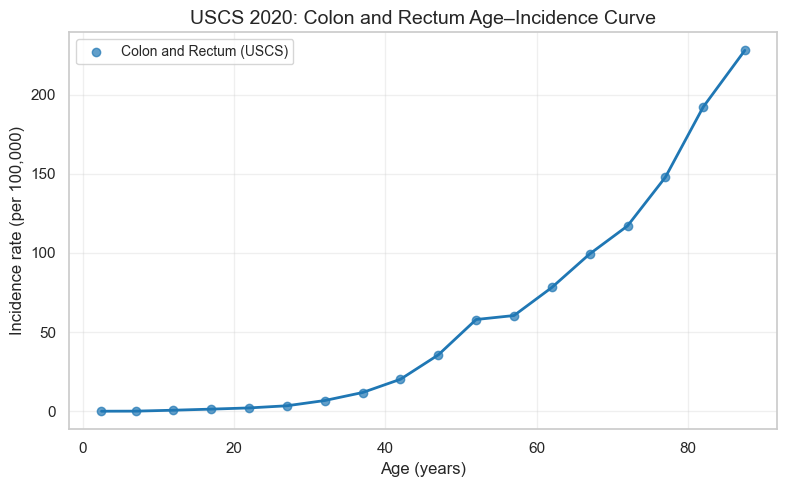

Colon and Rectum (USCS 2020):
  Data points: 18 age groups
  Age range: 2.5–87.5 years
  Incidence range: 0.0–227.9 per 100,000


In [98]:
# USCS age–incidence curve for Colon and Rectum (to complement all-sites analysis)
site_colon = "Colon and Rectum"

# Load USCS data if not already loaded in this session
try:
    brain_by_site
    by_age
except NameError:
    print("USCS data not yet loaded in this session; loading now...")
    brain_by_site, by_age = load_uscs_data()

# BYAGE has separate rows by sex; aggregate over sex to obtain an "all sexes" curve
colon_sex = by_age[
    (by_age["EVENT_TYPE"] == "Incidence")
    & (by_age["RACE"] == "All Races")
    & (by_age["SITE"] == site_colon)
].copy()

for col in ["COUNT", "POPULATION"]:
    colon_sex[col] = pd.to_numeric(colon_sex[col], errors="coerce")

colon_agg = (
    colon_sex
    .groupby(["AGE", "YEAR"], as_index=False)
    .agg({"COUNT": "sum", "POPULATION": "sum"})
)
colon_agg["RATE"] = colon_agg["COUNT"] / colon_agg["POPULATION"] * 100000.0

from src.utils import age_group_to_mid

colon_agg["AGE_MID"] = colon_agg["AGE"].apply(age_group_to_mid)
colon_agg = colon_agg[colon_agg["AGE_MID"].notna()].copy()

TARGET_YEAR = 2020
colon_year_df = colon_agg[
    pd.to_numeric(colon_agg["YEAR"], errors="coerce") == TARGET_YEAR
].copy()
colon_year_df = colon_year_df.sort_values("AGE_MID")

ages_colon = colon_year_df["AGE_MID"].values
rates_colon = colon_year_df["RATE"].values

plt.figure(figsize=(8, 5))
plt.scatter(ages_colon, rates_colon, color="tab:blue", alpha=0.7, label="Colon and Rectum (USCS)")
plt.plot(ages_colon, rates_colon, color="tab:blue", linewidth=2)
plt.xlabel("Age (years)", fontsize=12)
plt.ylabel("Incidence rate (per 100,000)", fontsize=12)
plt.title(f"USCS {TARGET_YEAR}: Colon and Rectum Age–Incidence Curve", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

print(f"Colon and Rectum (USCS {TARGET_YEAR}):")
print(f"  Data points: {len(ages_colon)} age groups")
print(f"  Age range: {ages_colon.min():.1f}–{ages_colon.max():.1f} years")
print(f"  Incidence range: {rates_colon.min():.1f}–{rates_colon.max():.1f} per 100,000")



## 1b. Lifelines colon survival snapshot (individual-level)

To complement the **USCS population-level incidence** view for colon and rectum,
we briefly summarize **individual-level colon cancer survival** using the
`lifelines` example dataset `data/lifelines/colon.csv`.

This mirrors the analysis in `visualization_examples.ipynb` and
`model_c_deterministic_hazard.ipynb` and helps link:

- How often colon cancer occurs at each age (USCS incidence).
- How patients fare after diagnosis at different ages (lifelines survival).



In [99]:
# Lifelines colon dataset: age vs event rate and follow-up time
colon_path = project_root / "data" / "lifelines" / "colon.csv"

if colon_path.exists():
    colon_df = pd.read_csv(colon_path)
    print(f"Loaded colon cancer survival dataset from: {colon_path}")
    print(f"Rows: {colon_df.shape[0]}, Columns: {colon_df.shape[1]}")
    print("Columns:", list(colon_df.columns))

    # Simple event indicator (any non-zero status)
    colon_df["event_any"] = (colon_df["status"] != 0).astype(int)

    # Age bands
    age_bins = [30, 50, 60, 70, 85]
    age_labels = ["30-49", "50-59", "60-69", "70-84"]
    colon_df["age_group"] = pd.cut(colon_df["age"], bins=age_bins, labels=age_labels, right=True)

    age_summary = (
        colon_df
        .groupby("age_group")
        .agg(
            n=("id", "count"),
            event_rate=("event_any", "mean"),
            median_time=("time", "median")
        )
        .reset_index()
    )

    print("\nAge-group summary (colon cancer dataset, lifelines):")
    display(age_summary)
else:
    print(f"colon.csv not found at: {colon_path}")
    print("Ensure data/lifelines/colon.csv exists if you wish to run this example.")



Loaded colon cancer survival dataset from: D:\资料\graduate\202509\INTRO-GENOMIC INFO SCI & TECH\FinalProject\data\lifelines\colon.csv
Rows: 1858, Columns: 17
Columns: ['Unnamed: 0', 'id', 'study', 'rx', 'sex', 'age', 'obstruct', 'perfor', 'adhere', 'nodes', 'status', 'differ', 'extent', 'surg', 'node4', 'time', 'etype']

Age-group summary (colon cancer dataset, lifelines):


C:\Users\35769\AppData\Local\Temp\ipykernel_31872\643087524.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("age_group")


,age_group,n,event_rate,median_time
0,30-49,366,0.530055,1597.5
1,50-59,496,0.455645,2032.0
2,60-69,606,0.523102,1663.5
3,70-84,362,0.464088,1875.0


## 2. Age-Specific Cancer Incidence Across Lifespan

Visualize how cancer incidence changes with age for all cancer sites combined.


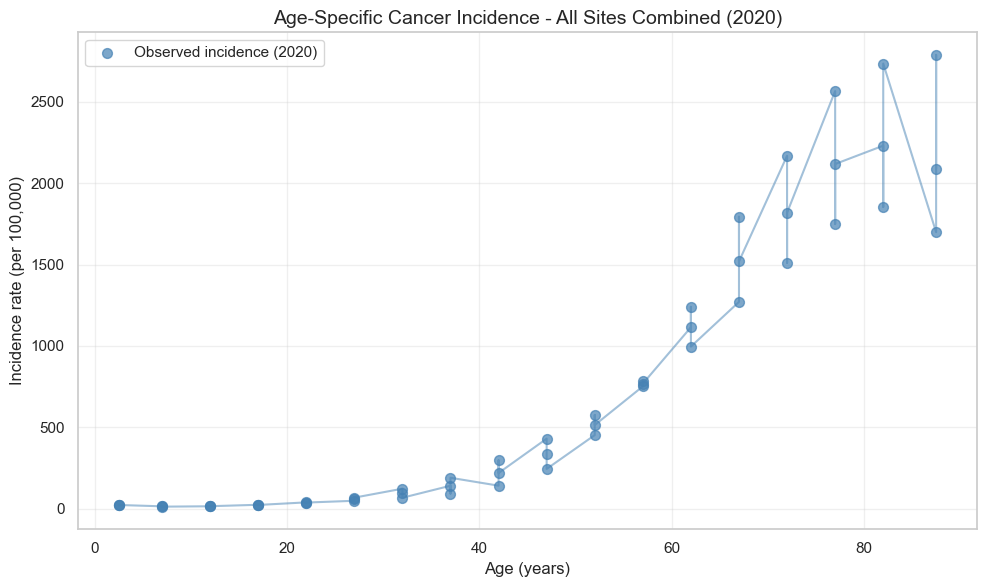

✓ Data points: 54 age groups
✓ Age range: 2.5 - 87.5 years
✓ Incidence range: 11.4 - 2788.5 per 100,000


In [100]:
# Prepare age-incidence data for 2020
TARGET_YEAR = 2020
ages, rates = prepare_age_incidence_data(all_sites_age_inc, target_year=TARGET_YEAR)

# Create visualization using the helper function
plot_age_incidence_curve(ages, rates, target_year=TARGET_YEAR)

print(f"✓ Data points: {len(ages)} age groups")
print(f"✓ Age range: {ages.min():.1f} - {ages.max():.1f} years")
print(f"✓ Incidence range: {rates.min():.1f} - {rates.max():.1f} per 100,000")


## 3. Model Predictions vs Empirical Data

Compare the probabilistic mutation accumulation model predictions with observed incidence data.


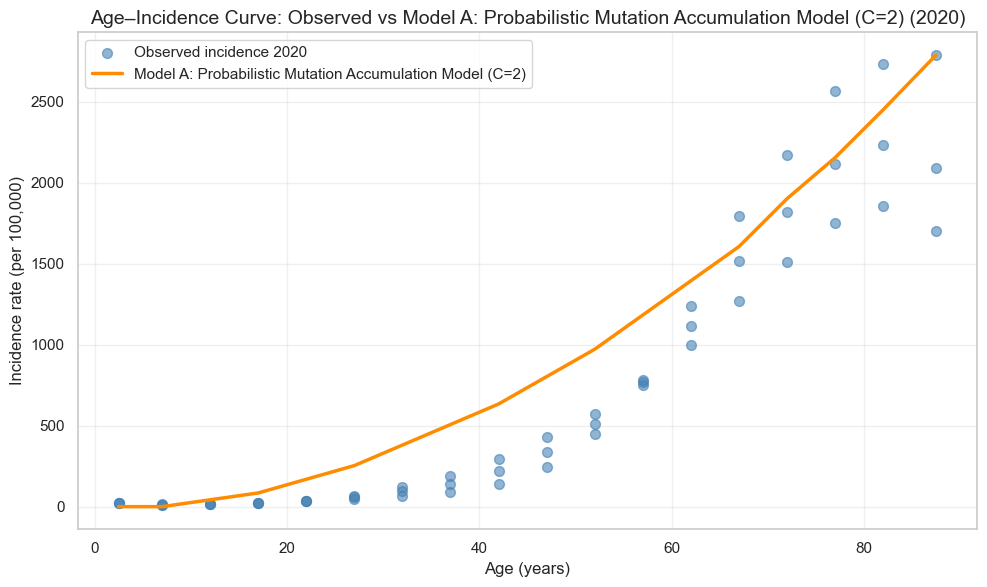


Model A Parameters:
  p (mutation probability) = 7.50e-10
  M (stem-cell clones) = 500,000
  Divisions per year = 1.85
  C (clonal threshold) = 2 (requires 2 driver mutations)


In [101]:
# Initialize model with optimized parameters for improved fit
# Fine-tuned to better match observed accelerating growth pattern:
# - Adjusted p (mutation probability) to enhance late-age acceleration
# - Optimized divisions_per_year to improve middle-to-old age transition
# - C=2 maintains nonlinear growth pattern with accelerating curve
model = MutationAccumulationModel(
    p=7.5e-10,                  # optimized per-division mutation probability
    M=500000,                   # number of stem-cell clones
    divisions_per_year=1.85,    # optimized divisions per year for better acceleration timing
    C=2                         # clonal threshold: requires 2 driver mutations for nonlinear growth
)

# Make predictions
predicted = model.predict_scaled(ages, scale_to_max=rates.max())

# Create comparison plot
plot_age_incidence_model(
    ages, rates,
    ages, predicted,
    target_year=TARGET_YEAR,
    model_label="Model A: Probabilistic Mutation Accumulation Model (C=2)"
)

# Print model parameters
params = model.get_parameters()
print(f"\nModel A Parameters:")
print(f"  p (mutation probability) = {params['p']:.2e}")
print(f"  M (stem-cell clones) = {params['M']:,}")
print(f"  Divisions per year = {params['divisions_per_year']}")
print(f"  C (clonal threshold) = {params['C']} (requires {params['C']} driver mutations)")


## 4. Nonlinear Growth: Effect of Clonal Threshold (C)

The model can produce nonlinear growth by requiring multiple driver mutations (C > 1) instead of a single hit (C = 1).


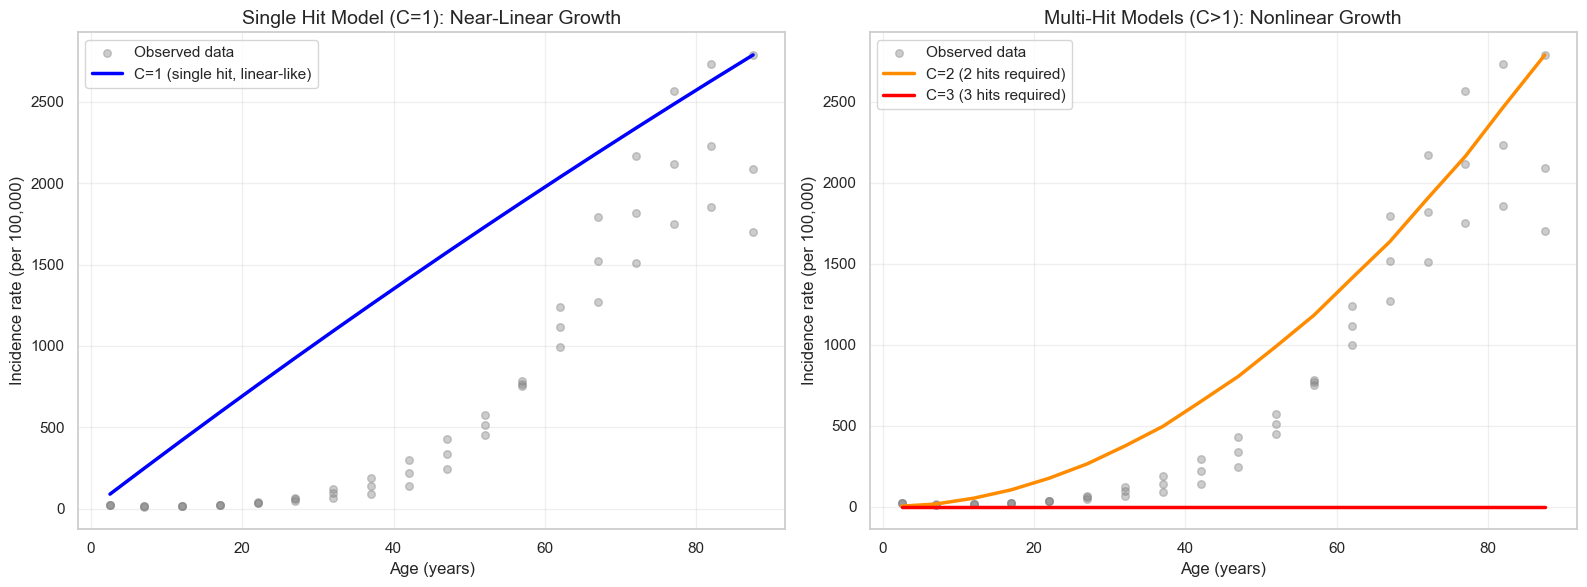

Note: Multi-hit models (C>1) produce nonlinear growth that better matches
the accelerating incidence pattern observed in real data at older ages.


In [102]:
# Compare single-hit (C=1, linear-like) vs multi-hit (C>1, nonlinear) models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left panel: Single hit (C=1) - produces near-linear growth
model_C1 = MutationAccumulationModel(p=2e-9, M=500000, divisions_per_year=2.5, C=1)
pred_C1 = model_C1.predict_scaled(ages, scale_to_max=rates.max())

axes[0].scatter(ages, rates, alpha=0.4, s=30, color='gray', label='Observed data', zorder=1)
axes[0].plot(ages, pred_C1, linewidth=2.5, color='blue', label='C=1 (single hit, linear-like)', zorder=2)
axes[0].set_xlabel('Age (years)', fontsize=12)
axes[0].set_ylabel('Incidence rate (per 100,000)', fontsize=12)
axes[0].set_title('Single Hit Model (C=1): Near-Linear Growth', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Right panel: Multiple hits (C=2, C=3) - produces nonlinear growth
model_C2 = MutationAccumulationModel(p=2e-9, M=500000, divisions_per_year=2.5, C=2)
model_C3 = MutationAccumulationModel(p=2e-9, M=500000, divisions_per_year=2.5, C=3)
pred_C2 = model_C2.predict_scaled(ages, scale_to_max=rates.max())
pred_C3 = model_C3.predict_scaled(ages, scale_to_max=rates.max())

axes[1].scatter(ages, rates, alpha=0.4, s=30, color='gray', label='Observed data', zorder=1)
axes[1].plot(ages, pred_C2, linewidth=2.5, color='darkorange', label='C=2 (2 hits required)', zorder=2)
axes[1].plot(ages, pred_C3, linewidth=2.5, color='red', label='C=3 (3 hits required)', zorder=2)
axes[1].set_xlabel('Age (years)', fontsize=12)
axes[1].set_ylabel('Incidence rate (per 100,000)', fontsize=12)
axes[1].set_title('Multi-Hit Models (C>1): Nonlinear Growth', fontsize=14)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Note: Multi-hit models (C>1) produce nonlinear growth that better matches")
print("the accelerating incidence pattern observed in real data at older ages.")


## 5. Model Fit Visualization and Residual Analysis

Create a comprehensive comparison showing model fit quality.


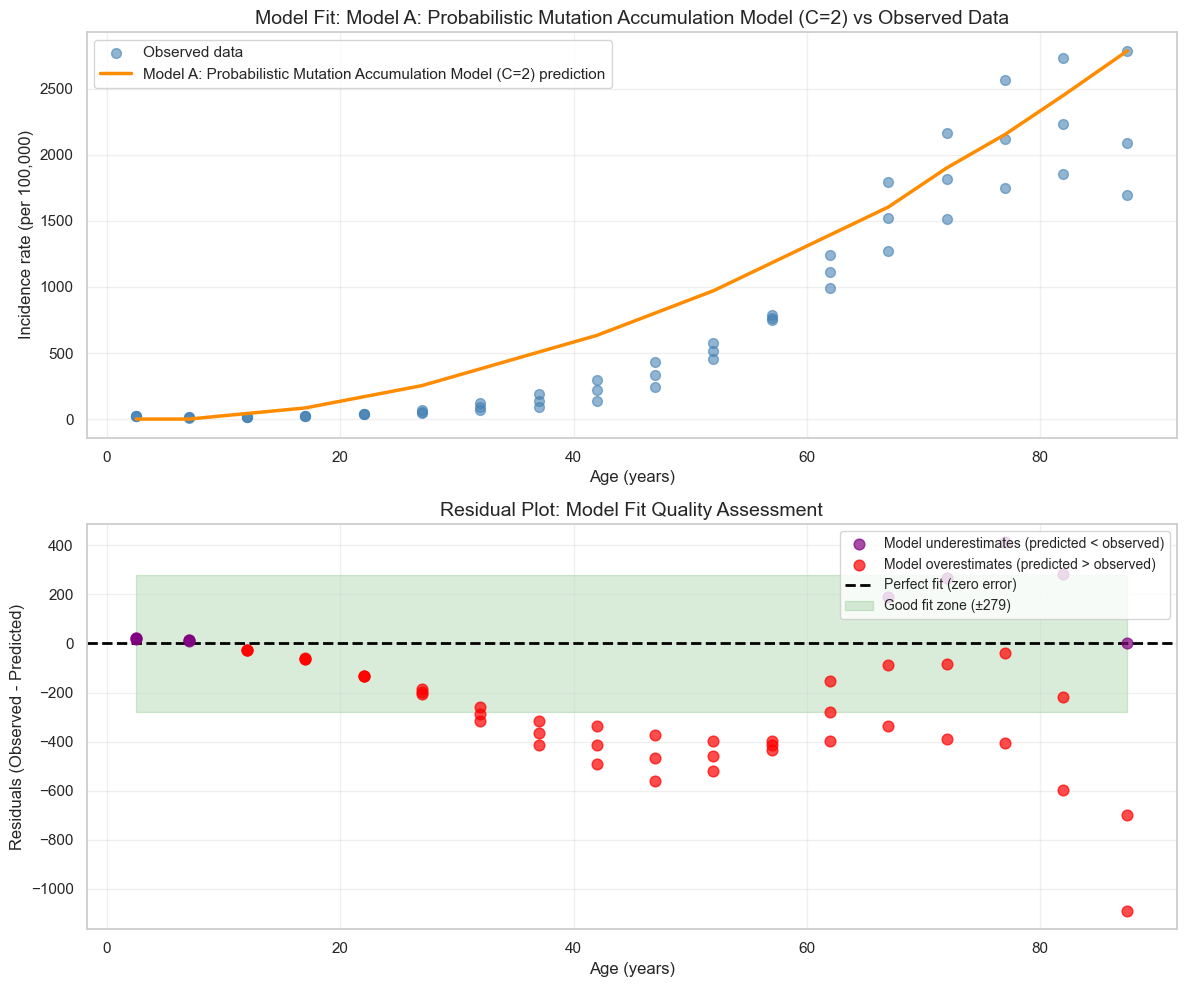


Model A Fit Statistics:
  Mean Squared Error (MSE): 117382.38
  R² Score: 0.8410
  Mean Absolute Error (MAE): 268.72
  Root Mean Squared Error (RMSE): 342.61


In [103]:
# Create a comprehensive model comparison plot with improved residual visualization
# Initialize model with optimized parameters for better fit
model = MutationAccumulationModel(p=7.5e-10, M=500000, divisions_per_year=1.85, C=2)
predicted = model.predict_scaled(ages, scale_to_max=rates.max())

# Use the improved residual analysis function
# This function creates a two-panel plot: model fit comparison and residual analysis
stats = plot_residual_analysis(ages, rates, predicted, model_label="Model A: Probabilistic Mutation Accumulation Model (C=2)")

# Print fit statistics
print(f"\n{'='*60}")
print(f"Model A Fit Statistics:")
print(f"{'='*60}")
print(f"  Mean Squared Error (MSE): {stats['mse']:.2f}")
print(f"  R² Score: {stats['r2']:.4f}")
print(f"  Mean Absolute Error (MAE): {stats['mae']:.2f}")
print(f"  Root Mean Squared Error (RMSE): {stats['rmse']:.2f}")


## 5. Parameter calibration for Model A via grid search

So far we have used hand-tuned parameters for the probabilistic
mutation-accumulation model. In this section we perform a simple **grid search**
to calibrate the model directly against the USCS age–incidence curve for
**all cancer sites combined** and for **colon and rectum**.

This provides:

- A data-driven estimate of the key parameters \(p\) (per-division mutation
  probability) and `divisions_per_year`.
- A comparison between **global** (all sites) and **site-specific** (colon)
  calibrations, which can be related to mutation burden patterns seen in TCGA.



In [104]:
# Grid search calibration for Model A (all sites vs colon and rectum)
from itertools import product
from sklearn.metrics import mean_squared_error

# Prepare all-sites age–incidence for a single year (same as in earlier cells)
TARGET_YEAR = 2020
all_df = all_sites_age_inc.copy()
from src.utils import age_group_to_mid
all_df["AGE_MID"] = all_df["AGE"].apply(age_group_to_mid)
all_df = all_df[all_df["AGE_MID"].notna()].copy()

all_year_df = all_df[
    pd.to_numeric(all_df["YEAR"], errors="coerce") == TARGET_YEAR
].copy()
all_year_df = all_year_df.sort_values("AGE_MID")

ages_all = all_year_df["AGE_MID"].values
rates_all = pd.to_numeric(all_year_df["RATE"], errors="coerce").values

# Colon and rectum (already computed above as colon_year_df, ages_colon, rates_colon)
try:
    ages_colon
    rates_colon
except NameError:
    print("Colon incidence arrays not found; please run the colon USCS cell above first.")

# Define coarse grids for p and divisions_per_year
p_grid = np.logspace(-10, -8, num=5)
divisions_grid = np.linspace(1.0, 3.0, num=5)

results = []

for p_val, div_val in product(p_grid, divisions_grid):
    # Use the same M and C for simplicity
    model_all = MutationAccumulationModel(
        p=p_val,
        M=500000,
        divisions_per_year=div_val,
        C=2,
    )
    pred_all = model_all.predict_scaled(ages_all, scale_to_max=rates_all.max())
    mse_all = mean_squared_error(rates_all, pred_all)

    model_colon = MutationAccumulationModel(
        p=p_val,
        M=500000,
        divisions_per_year=div_val,
        C=2,
    )
    pred_colon = model_colon.predict_scaled(ages_colon, scale_to_max=rates_colon.max())
    mse_colon = mean_squared_error(rates_colon, pred_colon)

    results.append({
        "p": p_val,
        "divisions_per_year": div_val,
        "mse_all_sites": mse_all,
        "mse_colon": mse_colon,
    })

results_df = pd.DataFrame(results)

print("Top 10 parameter settings by MSE for all sites:")
_display_cols = ["p", "divisions_per_year", "mse_all_sites", "mse_colon"]
best_all = results_df.sort_values("mse_all_sites").head(10)[_display_cols]
display(best_all)

print("\nTop 10 parameter settings by MSE for colon and rectum:")
best_colon = results_df.sort_values("mse_colon").head(10)[_display_cols]
display(best_colon)



Top 10 parameter settings by MSE for all sites:


,p,divisions_per_year,mse_all_sites,mse_colon
6,3.162278e-10,1.5,112277.164664,497.474264
7,3.162278e-10,2.0,113939.732702,522.885854
21,1.000000e-08,1.5,118279.144074,576.148610
16,3.162278e-09,1.5,118283.762671,575.859246
17,3.162278e-09,2.0,118941.483385,583.867746
22,1.000000e-08,2.0,118955.421728,583.732103
12,1.000000e-09,2.0,119760.321146,585.984031
11,1.000000e-09,1.5,119868.365752,603.023038
23,1.000000e-08,2.5,120157.093197,595.967303
18,3.162278e-09,2.5,120168.788795,596.111008



Top 10 parameter settings by MSE for colon and rectum:


,p,divisions_per_year,mse_all_sites,mse_colon
6,3.162278e-10,1.5,112277.164664,497.474264
7,3.162278e-10,2.0,113939.732702,522.885854
16,3.162278e-09,1.5,118283.762671,575.859246
21,1.000000e-08,1.5,118279.144074,576.148610
22,1.000000e-08,2.0,118955.421728,583.732103
17,3.162278e-09,2.0,118941.483385,583.867746
12,1.000000e-09,2.0,119760.321146,585.984031
9,3.162278e-10,3.0,120615.271134,595.712544
23,1.000000e-08,2.5,120157.093197,595.967303
18,3.162278e-09,2.5,120168.788795,596.111008


Using calibrated parameters from grid search (all sites best):
  p = 3.162e-10, divisions_per_year = 1.500


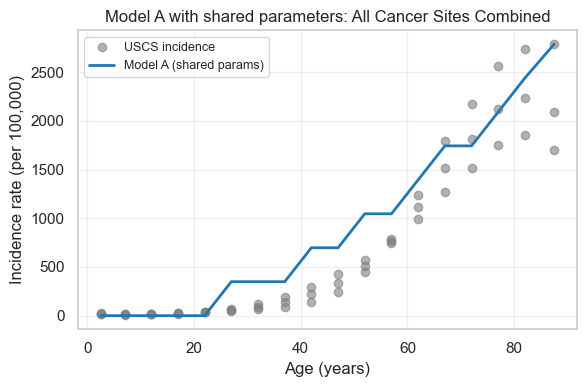

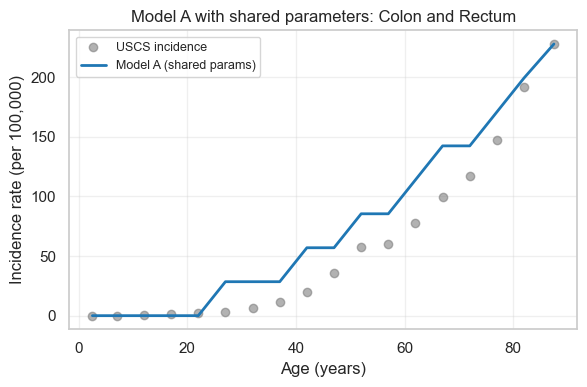

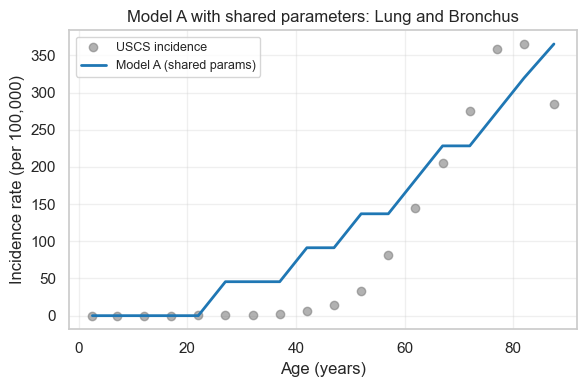

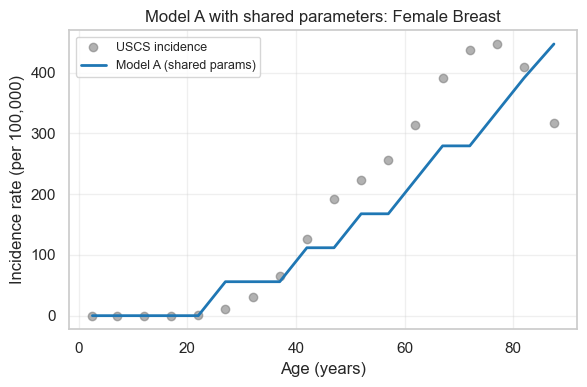

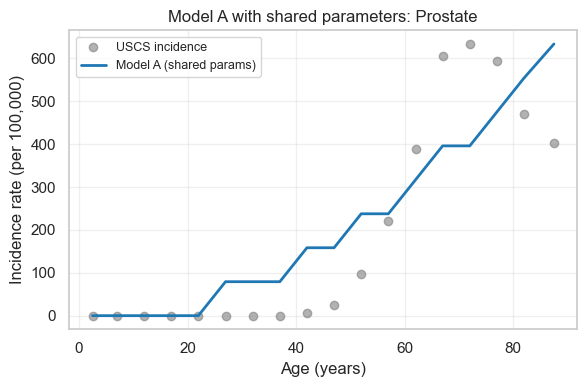

Model A multi-site performance (shared parameters, MSE):


,site,mse
0,All Cancer Sites Combined,112277.164664
1,Colon and Rectum,497.474264
2,Lung and Bronchus,2944.316527
3,Female Breast,5308.089144
4,Prostate,14490.650993


In [105]:
# 8. Multi-site evaluation of Model A using a single calibrated parameter set

# Choose a single calibrated parameter set from the grid search (best for all sites)
if 'results_df' in globals():
    best_row = results_df.sort_values("mse_all_sites").iloc[0]
    best_p = best_row["p"]
    best_div = best_row["divisions_per_year"]
    print("Using calibrated parameters from grid search (all sites best):")
    print(f"  p = {best_p:.3e}, divisions_per_year = {best_div:.3f}")
else:
    # Fallback to fixed values if grid search not executed
    best_p = 7.5e-10
    best_div = 1.85
    print("Grid search results not found; using default calibrated parameters.")

shared_model = MutationAccumulationModel(
    p=best_p,
    M=500000,
    divisions_per_year=best_div,
    C=2,
    r=0.0
)

selected_sites = [
    "All Cancer Sites Combined",
    "Colon and Rectum",
    "Lung and Bronchus",
    "Female Breast",
    "Prostate",
]

multi_rows = []
for site in selected_sites:
    if site == "All Cancer Sites Combined":
        ages_site, rates_site = ages, rates
    else:
        # Robust import in case the notebook kernel cached an older version of src.data_loader
        try:
            from src.data_loader import get_site_age_incidence
        except ImportError:
            import importlib
            import src.data_loader as _dl
            _dl = importlib.reload(_dl)
            get_site_age_incidence = getattr(_dl, "get_site_age_incidence")

        ages_site, rates_site, _df_site = get_site_age_incidence(by_age, site, target_year=TARGET_YEAR)
        if ages_site is None or len(ages_site) == 0:
            print(f"No incidence data found for site: {site}")
            continue

    pred_site = shared_model.predict_scaled(ages_site, scale_to_max=rates_site.max())
    mse_site = mean_squared_error(rates_site, pred_site)

    multi_rows.append({
        "site": site,
        "mse": mse_site,
    })

    # Optional: quick plot for each site
    plt.figure(figsize=(6, 4))
    plt.scatter(ages_site, rates_site, color="tab:gray", alpha=0.6, label="USCS incidence")
    plt.plot(ages_site, pred_site, color="tab:blue", linewidth=2, label="Model A (shared params)")
    plt.xlabel("Age (years)")
    plt.ylabel("Incidence rate (per 100,000)")
    plt.title(f"Model A with shared parameters: {site}")
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=9)
    plt.tight_layout()
    plt.show()

multi_df = pd.DataFrame(multi_rows)
print("Model A multi-site performance (shared parameters, MSE):")
display(multi_df)



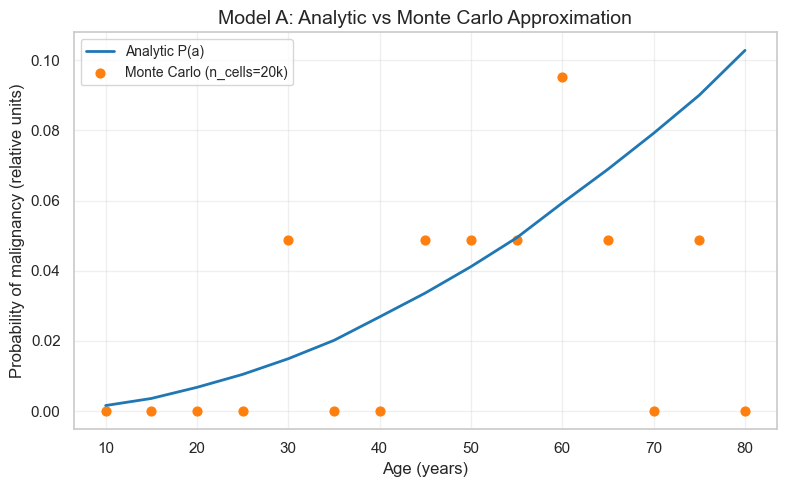

Max |analytic - MC| across grid: 0.10277737293549671
Mean |analytic - MC| across grid: 0.02706501919755692


In [108]:
# 6. Monte Carlo simulation vs analytic approximation for Model A

np.random.seed(42)

# Choose a coarser age grid to keep simulation feasible
ages_mc = np.linspace(10, 80, 15)

# IMPORTANT:
# For Monte Carlo, if we use the extremely small, calibrated p (~1e-10)
# and large M (5e5), the true malignancy probability is ~1e-9.
# In that regime, even with 20k simulated cells we almost never see
# a malignant clone, so the orange points collapse to ~0 on the plot.
#
# To *visually* check that the stochastic simulator matches the
# analytic formula, we use a "toy" parameter set with larger p
# and smaller M so that P(a) is in a numerically visible range
# (e.g. 1e-3–1e-1). This does not change the shape logic; it just
# makes the Monte Carlo curve observable.
mc_model = MutationAccumulationModel(
    p=1e-4,          # toy per-division driver probability (much larger than calibrated)
    M=1000,          # toy number of effective stem-cell clones (smaller than calibrated)
    divisions_per_year=1.85,
    C=2,
    r=0.0,
)

# Analytic prediction
P_analytic = mc_model.predict(ages_mc)

# Monte Carlo simulation: number of cells per tissue
n_cells = 20000
p_eff = mc_model.p * (1 - mc_model.r)

P_mc = []
for a in ages_mc:
    N = int(a * mc_model.divisions_per_year)
    if N <= 0 or p_eff <= 0:
        P_mc.append(0.0)
        continue
    # Simulate number of driver hits per cell
    hits = np.random.binomial(N, p_eff, size=n_cells)
    frac_clones_malignant = (hits >= mc_model.C).mean()
    P_tissue_mc = 1 - (1 - frac_clones_malignant) ** mc_model.M
    P_mc.append(P_tissue_mc)

P_mc = np.array(P_mc)

# Compare analytic vs Monte Carlo
plt.figure(figsize=(8, 5))
plt.plot(ages_mc, P_analytic, label="Analytic P(a)", color="tab:blue", linewidth=2)
plt.scatter(ages_mc, P_mc, label="Monte Carlo (n_cells=20k)", color="tab:orange", s=40)
plt.xlabel("Age (years)", fontsize=12)
plt.ylabel("Probability of malignancy (relative units)", fontsize=12)
plt.title("Model A: Analytic vs Monte Carlo Approximation", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

abs_diff = np.abs(P_analytic - P_mc)
print("Max |analytic - MC| across grid:", abs_diff.max())
print("Mean |analytic - MC| across grid:", abs_diff.mean())



In [107]:
# 7. Ablation study on clonal threshold C and repair efficiency r

TARGET_YEAR = 2020
ages_all, rates_all = prepare_age_incidence_data(all_sites_age_inc, target_year=TARGET_YEAR)

C_values = [1, 2, 3]
r_values = [0.0, 0.3, 0.6]

ablation_rows = []
for C_val in C_values:
    for r_val in r_values:
        model_ab = MutationAccumulationModel(
            p=7.5e-10,       # keep p and divisions_per_year fixed from calibrated model
            M=500000,
            divisions_per_year=1.85,
            C=C_val,
            r=r_val,
        )
        pred = model_ab.predict_scaled(ages_all, scale_to_max=rates_all.max())
        mse = mean_squared_error(rates_all, pred)
        ablation_rows.append({
            "C": C_val,
            "r": r_val,
            "mse_all_sites": mse,
        })

ablation_df = pd.DataFrame(ablation_rows)
print("Ablation study on C and r (USCS all sites, MSE):")
display(ablation_df.pivot(index="C", columns="r", values="mse_all_sites"))



Ablation study on C and r (USCS all sites, MSE):


r,0.0,0.3,0.6
C,,,
1,6.318409e+05,6.249669e+05,6.181336e+05
2,1.173824e+05,1.172957e+05,1.002372e+05
3,1.285947e+06,1.285947e+06,1.285947e+06
